In [ ]:
! pip install seaborn


In [ ]:
import sys
print(sys.executable)
print(sys.version)

cosas por hacer 
 el análisis de un dataset y el entrenamiento de un modelo para la recomendación de cultivos a sembrar según la composición de un terreno y las condiciones climáticas del área.

 preprocesar el dataset segun sea lo necesario
    -podria se aqui mas como sacar bien los rangos de cada parametro segun la etiqueta
    -ademas de ver datos que esten fuera de la distribucion y matarlos para que no genere tanto ruido
    -ver como varia los datos entre cada labe pudiendo tener un minimo y un maximo
    -usar histogramas con pandas y regularizar datos

 para el entrenamiento 

1. Considerando el dataset anterior, implemente un bucle de entrenamiento de la tarea correspondiente.

2. Al terminar el entrenamiento del bucle, debe tener una función en la cual se le pase un vector de datos y retorne la inferencia correspondiente.

3. El bucle debe mostrar las curvas de las funciones de cost para entrenamiento y validación, así como las métricas relevantes.

4. A su vez, realizar comparaciones entre desempeño usando al menos tres arquitecturas de modelos distintas.
-podria ser usar softmax para sacar probabilidades
-



In [ ]:
# preprocesamiento

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Carga CSV (ajusta ruta relativa)
df = pd.read_csv('Crop_recommendation.csv')

cols = ["N", "P", "K", "temperature", "humidity", "ph", "rainfall"]
cultivos = df['label'].unique()

for col in cols:
    n_cultivos = len(cultivos)
    ncols = 3  # columnas en la grilla (ajusta según te guste)
    nrows = (n_cultivos + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), squeeze=False)
    fig.suptitle(f'Histogramas de {col} por cultivo', fontsize=16)

    for i, cultivo in enumerate(cultivos):
        ax = axes[i // ncols, i % ncols]
        subset = df[df['label'] == cultivo]
        sns.histplot(subset[col], bins=20, kde=False, color="skyblue", ax=ax)
        ax.set_title(f'Cultivo: {cultivo}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frecuencia')

    # Quitar ejes vacíos si cultivos no llenan la grilla
    for j in range(i+1, nrows*ncols):
        fig.delaxes(axes[j // ncols, j % ncols])

    #plt.tight_layout(rect=[0, 0, 1, 0.96])
    #plt.show()



In [ ]:
for col in cols:
    plt.figure(figsize=(14, 6))
    sns.boxplot(x='label', y=col, data=df)
    plt.title(f'Distribución de {col} por cultivo (label)', fontsize=14)
    plt.xticks(rotation=45)
    plt.xlabel('Cultivo')
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
#Descatarmo elementos nulos
# Ver cuántos valores nulos hay antes
print("Valores nulos por columna:")
print(df.isnull().sum())

#no hay valores nulos

#verificamos que el tamaño de los datos por cada label sea igual que los demas 
#evitando el desbalanceo de los datos, perjudicando el entrenamiento

# Verificamos el tamaño de cada label
print("Tamaño de cada label:")
print(df['label'].value_counts())

print("cantidad de labels")
print(df['label'].nunique())




In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch.nn.functional as F

class CropDataset(Dataset):
    def __init__(self, csv_path, export_path=None):
        df = pd.read_csv(csv_path)

        self.feature_columns = df.columns[:-1]
        self.label_column = df.columns[-1]

        # Codificar etiquetas a números
        
        unique_labels = df[self.label_column].unique()
        self.label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
        
        #generacion de la columna de label encoded
        df['encoded_label'] = df[self.label_column].map(self.label_mapping)

        for crop, idx in self.label_mapping.items():
            print(f"Label: {crop}, Encoded: {idx}")
        



        # Normalización global
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(df[self.feature_columns])
        normalized_df = pd.DataFrame(scaled_features, columns=self.feature_columns)
        normalized_df['label'] = df[self.label_column]
        normalized_df['encoded_label'] = df['encoded_label']

        # Mezclar datos (shuffle)
        normalized_df = normalized_df.sample(frac=1).reset_index(drop=True)

        # Guardar CSV si se especifica ruta
        if export_path:
            normalized_df.to_csv(export_path, index=False)
            print(f"[INFO] CSV exportado en: {export_path}")

        # Convertir a tensores
        self.X = torch.tensor(normalized_df[self.feature_columns].values, dtype=torch.float32)
        self.y = torch.tensor(normalized_df['encoded_label'].values, dtype=torch.long)

        self.num_classes = len(unique_labels)
        

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def get_x_y(self):
        return self.X, self.y
    
    def get_label_mapping(self):
        return self.label_mapping



In [3]:
dataset = CropDataset("Crop_recommendation.csv", export_path="Crop_recommendation_normalized.csv")


Label: rice, Encoded: 0
Label: maize, Encoded: 1
Label: chickpea, Encoded: 2
Label: kidneybeans, Encoded: 3
Label: pigeonpeas, Encoded: 4
Label: mothbeans, Encoded: 5
Label: mungbean, Encoded: 6
Label: blackgram, Encoded: 7
Label: lentil, Encoded: 8
Label: pomegranate, Encoded: 9
Label: banana, Encoded: 10
Label: mango, Encoded: 11
Label: grapes, Encoded: 12
Label: watermelon, Encoded: 13
Label: muskmelon, Encoded: 14
Label: apple, Encoded: 15
Label: orange, Encoded: 16
Label: papaya, Encoded: 17
Label: coconut, Encoded: 18
Label: cotton, Encoded: 19
Label: jute, Encoded: 20
Label: coffee, Encoded: 21
[INFO] CSV exportado en: Crop_recommendation_normalized.csv


In [33]:
X, y = dataset[0]
print("Features (X):", X)
print("Etiqueta y", y)
print("Forma de y:", y.shape)

Features (X): tensor([-0.8819,  0.7774, -0.5559, -1.0550, -2.1675, -0.7653,  0.6604])
Etiqueta y tensor(3)
Forma de y: torch.Size([])


**Genertacion del dataSet**

In [4]:
from torch.utils.data import random_split, DataLoader
x, y = dataset.get_x_y()
#dataset reunido

dataset_tratado = torch.utils.data.TensorDataset(x, y)

# Dividir el dataset en entrenamiento y prueba
#70% entrenamiento, 30% prueba
train, val = random_split(dataset_tratado, [int(len(dataset_tratado) * 0.6), int(len(dataset_tratado) * 0.4)])
#genera los dataloaders
#ademas de aplicar el shuffle, para utilizar el teorema de limite central
train = DataLoader(train, batch_size=32, shuffle=True)
val= DataLoader(val, batch_size=32, shuffle=True)


In [5]:
def earlyStopping(val_losses, train_losses, best_moving_avg_loss,
                  patience, epochs_without_improvement, window_size):
    """
    Revisa si debe activarse early stopping basado en la media móvil del validation loss.

    Retorna:
        stop (bool): True si se debe detener el entrenamiento
        best_moving_avg_loss (float): actualizado si hay mejora
        epochs_without_improvement (int): actualizado
    """
    stop = False
    if len(val_losses) >= window_size:
        moving_avg = sum(val_losses[-window_size:]) / window_size
        print("Media móvil del loss de validación:", moving_avg)

        if moving_avg < best_moving_avg_loss:
            best_moving_avg_loss = moving_avg
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print("Nueva mejor media móvil. Modelo guardado.")
        else:
            epochs_without_improvement += 1
            print("No hubo mejora en el loss de validación.")
            print("Épocas sin mejora:", epochs_without_improvement, "de", patience)
            if epochs_without_improvement >= patience:
                print("Detención temprana activada por falta de mejora.")
                stop = True

    return stop, best_moving_avg_loss, epochs_without_improvement

Epoca 1/1000 : Train Loss: 2.8953, Validation Loss: 2.6130
Epoca 2/1000 : Train Loss: 2.2250, Validation Loss: 1.7760
Epoca 3/1000 : Train Loss: 1.3672, Validation Loss: 1.0271
Epoca 4/1000 : Train Loss: 0.8051, Validation Loss: 0.6422
Epoca 5/1000 : Train Loss: 0.5326, Validation Loss: 0.4604
Media móvil del loss de validación: 1.303751105070114
Nueva mejor media móvil. Modelo guardado.
Epoca 6/1000 : Train Loss: 0.3904, Validation Loss: 0.3596
Media móvil del loss de validación: 0.8530642330646515
Nueva mejor media móvil. Modelo guardado.
Epoca 7/1000 : Train Loss: 0.3045, Validation Loss: 0.2776
Media móvil del loss de validación: 0.553376066684723
Nueva mejor media móvil. Modelo guardado.
Epoca 8/1000 : Train Loss: 0.2554, Validation Loss: 0.2321
Media móvil del loss de validación: 0.3943644821643829
Nueva mejor media móvil. Modelo guardado.
Epoca 9/1000 : Train Loss: 0.2130, Validation Loss: 0.2081
Media móvil del loss de validación: 0.3075422763824463
Nueva mejor media móvil. Mod

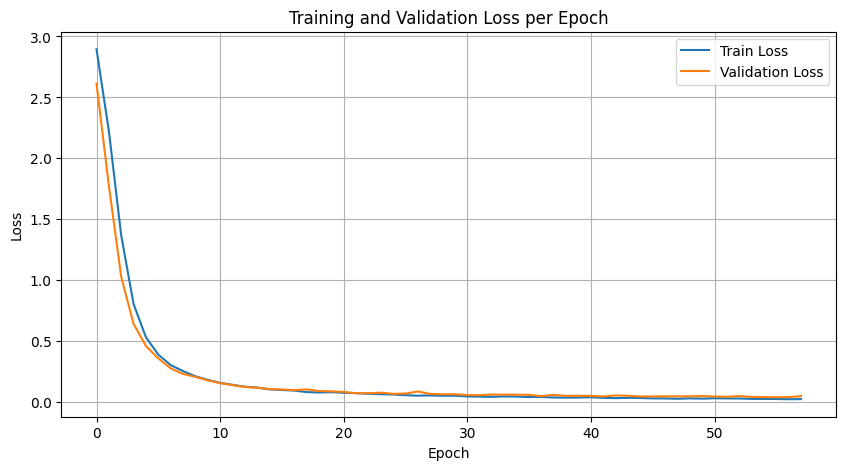

In [7]:
#Generacion de los modelos 
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


class DropClassifier(torch.nn.Module):

    def __init__(self, n_classes, input_size=7, hidden_size=64):
      super(DropClassifier, self).__init__()

      self.encoder = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, n_classes)
      )


    def forward(self, x):
        x = x.view(x.size(0), -1)
        y_hat = self.encoder(x)
        return y_hat

#activamos la gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#cargamos el modelo en la gpu

 #definimos el modelo
n_classes = 22
model = DropClassifier(n_classes)
params = model.parameters()
optimizer = torch.optim.Adam(params, lr=0.001) #adam es un optimizador

#cargamos el modelo en la gpu
model.to(device)

num_epochs = 1000

train_losses = []#listas para graficacion
val_losses = []



window_size = 5
patience = 5
epochs_without_improvement = 0
best_moving_avg_loss = float('inf')
abs_differences = []  # lista para guardar |val_loss - train_loss|
best_epoch = 0

#primero enta en modo de entrenamiento por cada epoca con su reponsable batch
for epoch in range(num_epochs):
    losses = []

    for train_batch in train:
        x, y = train_batch
        if torch.cuda.is_available():
            x = x.cuda(0)
            y = y.cuda(0)

        y_hat = model(x)
        loss = nn.functional.cross_entropy(y_hat, y)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


    losses = torch.mean(torch.tensor(losses))
    train_losses.append(losses.item())
    

    # Validación cada epoch para asi determinar si esta mejorando nuestro modelo o si esta overfitting
    model.eval()
    with torch.no_grad():
        val_loss = []

        for val_batch in val:
            x, y = val_batch
            if torch.cuda.is_available():
                x = x.cuda(0)
                y = y.cuda(0)

            y_hat = model(x)
            loss = nn.functional.cross_entropy(y_hat, y)
            val_loss.append(loss.item())

        val_loss = torch.mean(torch.tensor(val_loss))
        val_losses.append(val_loss.item())
       

        print(f"Epoca {epoch + 1}/{num_epochs} : Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")



        # Verificación de early stopping
        stop, best_moving_avg_loss, epochs_without_improvement = earlyStopping(
            val_losses, train_losses, best_moving_avg_loss,
            patience, epochs_without_improvement, window_size
        )
        if stop:
            best_epoch = epoch - epochs_without_improvement
            break

    model.train()

if len(val_losses) > best_epoch:
    #quitamos las epocas que no nos importan
    val_losses = val_losses[:best_epoch + 1]
    train_losses = train_losses[:best_epoch + 1]

print("Best epoch:", best_epoch)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
#generacion de las metricas de prediccion
#es decirla matriz de confucion
import numpy as np

matriz_confusion = np.zeros((n_classes, n_classes))

model.eval()
with torch.no_grad():
    for x_batch, y_batch in val:
        if torch.cuda.is_available():
            x_batch = x_batch.cuda(0)
            y_batch = y_batch.cuda(0)
        y_pred = model(x_batch)
        preds = torch.argmax(y_pred, dim=1)
        for t, p in zip(y_batch.view(-1), preds.view(-1)):
            matriz_confusion[t.long(), p.long()] += 1

# Calcular métricas ´por clase
precision = []
recall = []
f1_score = []
accuracy_por_clase = []

for i in range(n_classes):
    TP = matriz_confusion[i, i]
    FP = matriz_confusion[:, i].sum() - TP
    FN = matriz_confusion[i, :].sum() - TP
    TN = matriz_confusion.sum() - (TP + FP + FN)

    precision_i = TP / (TP + FP)
    recall_i = TP / (TP + FN) 
    f1_score_i = 2 * ((precision_i * recall_i) / (precision_i + recall_i))
    accuracy_i = (TP + TN) / (TP+ TN + FP + FN)

    precision.append(precision_i)
    recall.append(recall_i)
    f1_score.append(f1_score_i)
    accuracy_por_clase.append(accuracy_i)

# Metricas globales
precision_global = np.mean(precision)
recall_global = np.mean(recall)
f1_score_global =  2 * (precision_global * recall_global) / (precision_global + recall_global) if (precision_global + recall_global) > 0 else 0
accuracy_global = np.mean(accuracy_por_clase)

label_mapping = dataset.get_label_mapping()

inverse_label_mapping = {v: k for k, v in label_mapping.items()}
classes = [inverse_label_mapping[i] for i in range(n_classes)]

# Imprimir métricas
df = pd.DataFrame({
    'Cultivo': classes,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_score,
    'Accuracy': accuracy_por_clase
})
df.loc["Globales"] = ["—", precision_global, recall_global, f1_score_global, accuracy_global]

print("\nMétricas por clase:")
print(df)



Métricas por clase:
              Cultivo  Precision    Recall  F1 Score  Accuracy
0                rice   0.902439  0.948718  0.925000  0.993182
1               maize   1.000000  1.000000  1.000000  1.000000
2            chickpea   1.000000  1.000000  1.000000  1.000000
3         kidneybeans   0.947368  1.000000  0.972973  0.997727
4          pigeonpeas   1.000000  0.948718  0.973684  0.997727
5           mothbeans   0.970588  0.942857  0.956522  0.996591
6            mungbean   1.000000  1.000000  1.000000  1.000000
7           blackgram   0.972973  1.000000  0.986301  0.998864
8              lentil   0.957447  0.957447  0.957447  0.995455
9         pomegranate   1.000000  1.000000  1.000000  1.000000
10             banana   1.000000  1.000000  1.000000  1.000000
11              mango   1.000000  1.000000  1.000000  1.000000
12             grapes   1.000000  1.000000  1.000000  1.000000
13         watermelon   1.000000  1.000000  1.000000  1.000000
14          muskmelon   1.000000  